### Importing Packages and Data Preparation

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import shap
import os

In [2]:
# Load the breast cancer dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)

# Add the target column to the DataFrame
df['target'] = data.target

# Split the data into X (features) and y (target)
X = df.drop('target', axis=1)  # Features
y = df['target']  # Target variable
        
threshold = np.mean(y)
y_binary = (y > threshold).astype(int)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

### Setting up the Hyperparatmeters Set and the Classifer

The "Safety" class sets up hyperparameter grids for Logistic Regression, Random Forest, and Support Vector classifier, as well as setting up a GridSearch cross-validation. There is also a function that saves the best random state of a model depending on it's recall score.

In [3]:
class Safety():
    
    def __init__(self, model):
        if model:
            self.model = model
        else:
            self.model = ""
        
        if model == "logreg":
            self.param_grid = {
                    'C': [0.001, 0.01, 0.1, 1, 10, 100],
                    'penalty': ['l2'],
                    'solver': ['newton-cg', 'liblinear'],
                    'max_iter': [200, 300, 500, 1000],
                    'class_weight': [None, 'balanced'],
                }
        elif model == "rf":
            self.param_grid = {
                    'n_estimators': [10, 20, 30],
                    'max_depth': [None, 10, 20, 30],
                    'min_samples_split': [3, 5, 7],
                    'min_samples_leaf': [1, 2, 4]
                }
        elif model == "svc":
            self.param_grid = {
                    'C': [1, 10, 100, 1000],
                    'kernel': ['linear', 'rbf'],
                    'gamma': [0.001, 0.0001]
                }
    
    def cross_val(self, model):
        # Create the GridSearchCV object
        grid_search = GridSearchCV(model, self.param_grid, cv=5, scoring='recall', n_jobs=-1, error_score='raise')

        # Fit the GridSearchCV object to the data
        grid_search.fit(X_train_scaled, y_train_resampled)

        # Print the best hyperparameters found
        print("Best Hyperparameters:", grid_search.best_params_)

        # Get the best model
        best_model = grid_search.best_estimator_

        # Make predictions on the test set using the best model
        y_pred_grid = best_model.predict(X_test_scaled)
        
        # Fit the best model on the training set
        best_model.fit(X_train_scaled, y_train_resampled)
        
        # Summarize the background data using kmeans
        background_data_summary = shap.kmeans(X_train, 10)

        # Create a SHAP explainer object using KernelExplainer and the summarized background data
        if isinstance(best_model, SVC):
            # Enable probability estimates for SVC
            explainer = shap.KernelExplainer(best_model.predict_proba, background_data_summary, feature_names=df.columns)
            # Use decision function instead of predict_proba
            y_pred_decision = best_model.decision_function(X_test_scaled)
        else:
            explainer = shap.KernelExplainer(best_model.predict_proba, background_data_summary, feature_names=df.columns)         
                
        # Calculate SHAP values for the test set
        shap_values = explainer.shap_values(X_test_scaled)

        # Evaluate the model with the best hyperparameters using recall
        recall_grid = recall_score(y_test, y_pred_grid)
        conf_matrix_grid = confusion_matrix(y_test, y_pred_grid)
        classification_report_str_grid = classification_report(y_test, y_pred_grid)

        TP = int(conf_matrix_grid[0][0])
        FP = int(conf_matrix_grid[0][1])
        FN = int(conf_matrix_grid[1][0])

        # Display the results
        print(f"\nBest Model Recall: {recall_grid:.4f}")
        print("\nConfusion Matrix (Best Model):")
        print(conf_matrix_grid)
        print("\nClassification Report (Best Model):")
        print(classification_report_str_grid)
        
        # Outer Loop: Perform nested cross-validation with outer cross-validation
        nested_cv_scores = cross_val_score(grid_search, X_train_scaled, y_train_resampled, cv=5, scoring='recall')

        # Calculate the mean and standard deviation of the nested cross-validation scores
        mean_nested_cv_score = np.mean(nested_cv_scores)
        std_nested_cv_score = np.std(nested_cv_scores)

        print(f"Mean Recall across Nested Cross-Validation: {mean_nested_cv_score:.4f}")
        print(f"Standard Deviation of Recall across Nested Cross-Validation: {std_nested_cv_score:.4f}")

        # Compute ROC AUC score
        if isinstance(best_model, SVC):
            roc_auc = roc_auc_score(y_test, y_pred_decision)
            print(f"\nROC AUC Score: {roc_auc:.4f}")
            
            # Plot ROC curve
            fpr, tpr, _ = roc_curve(y_test, y_pred_decision)
            roc_auc = auc(fpr, tpr)
        else:
            roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test_scaled)[:, 1])
            print(f"\nROC AUC Score: {roc_auc:.4f}")
            
            # Plot ROC curve
            fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test_scaled)[:, 1])
            roc_auc = auc(fpr, tpr)
        
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = {:.2f})'.format(roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic Curve')
        plt.legend(loc="lower right")
        plt.show()
        
        # Get the explanations for the positive class
        shap_values_positive_class = shap_values[1]

        # Create an Explanation object for a specific sample
        sample_idx = 7
        shap_value_sample = shap_values_positive_class[sample_idx]
        sample = X_test_scaled[sample_idx]  # Select the corresponding sample

        expl = shap.Explanation(values=shap_value_sample, base_values=explainer.expected_value[1], data=sample, feature_names=X_test.columns)

        # Visualize the waterfall plot for the Explanation object
        shap.plots.waterfall(expl)
        
        if isinstance(best_model, LogisticRegression):
            shap.summary_plot(shap_values, X_test, feature_names=data.feature_names)
        
    def random_state_recall(self, repetitions):

        best_rec = 0

        # Initialize a list to store accuracy scores
        recall = []

        # Repeat the train/test split 100 times with different random seeds
        for i in range(repetitions):
            random_state = i  # Use i as the random seed

            # Split the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

            # Standardize the features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Apply SMOTE to oversample the minority class in the training set
            smote = SMOTE(random_state=i)
            X_train_scaled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

            if self.model == "logreg":
                # Define the logistic regression model
                model = LogisticRegression(random_state=random_state)
                model.fit(X_train_scaled, y_train_resampled)
            elif self.model == "rf":
                model = RandomForestClassifier(random_state=random_state)
                model.fit(X_train_scaled, y_train_resampled)
            elif self.model == "svc":
                model = SVC(random_state=random_state)
                model.fit(X_train_scaled, y_train_resampled)

            # Make predictions on the test set
            y_pred = model.predict(X_test_scaled)

            # Calculate recall score and append it to the list
            rec = recall_score(y_test, y_pred)
            recall.append(rec)

            if rec > best_rec:
                best_rec = rec
                best_state = random_state


        # Plot a boxplot of the accuracies
        plt.boxplot(recall)
        plt.title('Boxplot of Recalls across 100 Random States')
        plt.xticks([1],[self.model])
        plt.ylabel('Recall')
        plt.show()

        print(f"Best random state is {best_state} with recall of {best_rec}")

### Safety analysis on a Logistic Regression model

#### Grid Search

Best Hyperparameters: {'C': 0.01, 'class_weight': None, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}


KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


  0%|          | 0/114 [00:00<?, ?it/s]


Best Model Recall: 1.0000

Confusion Matrix (Best Model):
[[41  2]
 [ 0 71]]

Classification Report (Best Model):
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        43
           1       0.97      1.00      0.99        71

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Mean Recall across Nested Cross-Validation: 0.9930
Standard Deviation of Recall across Nested Cross-Validation: 0.0085

ROC AUC Score: 0.9984


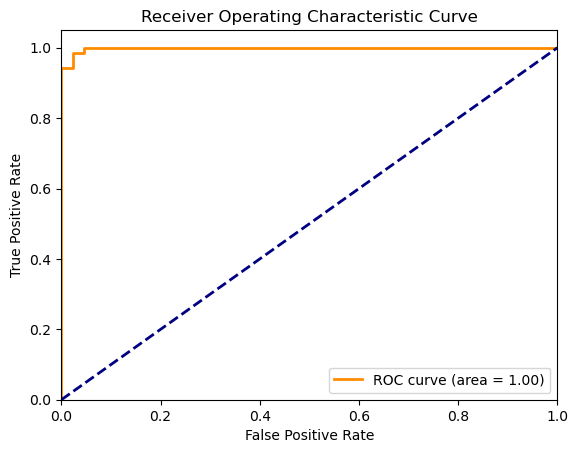

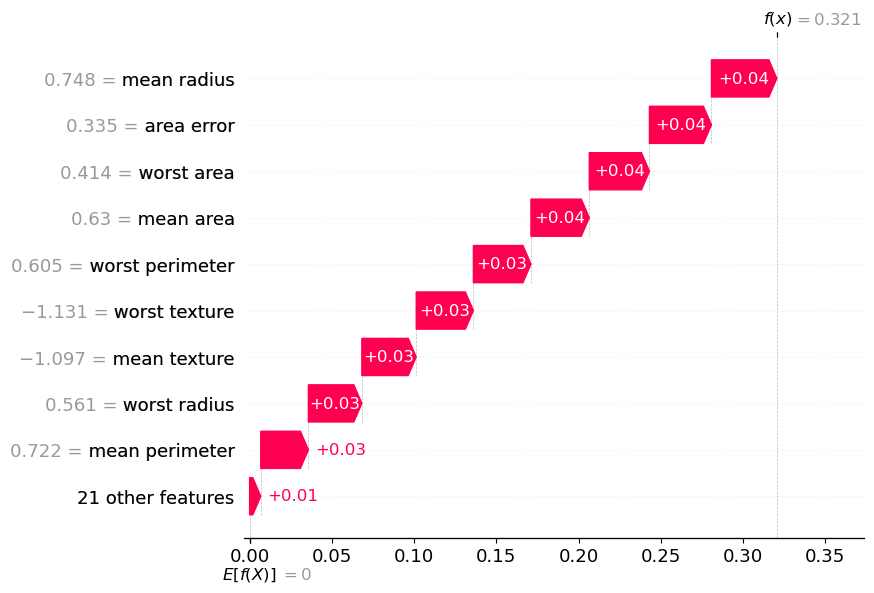

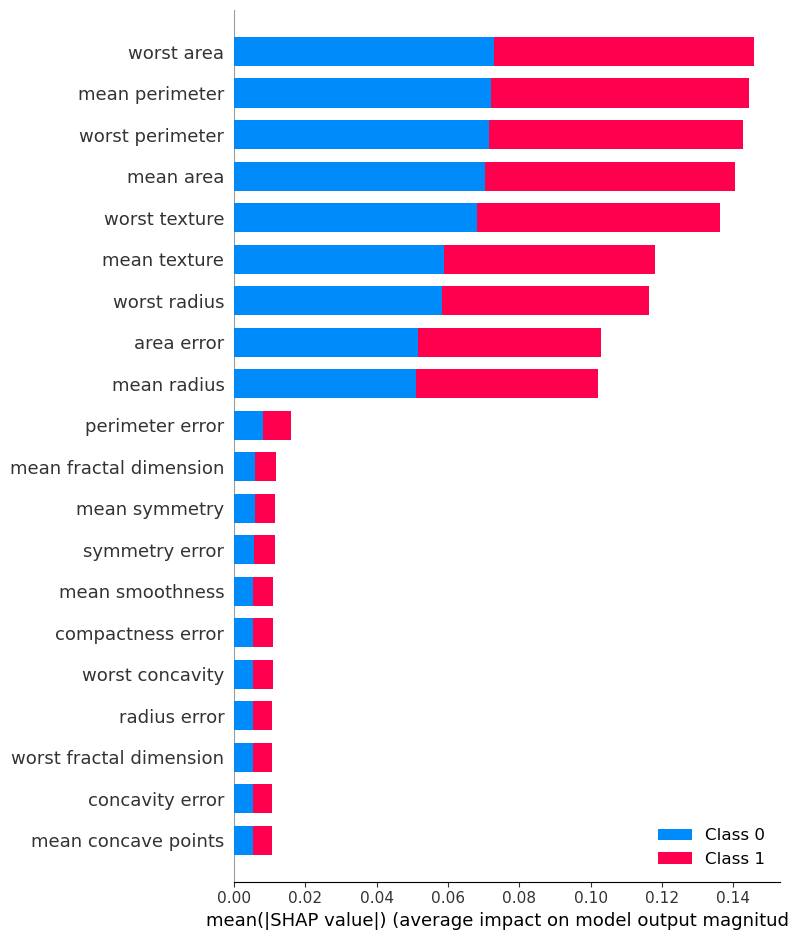

In [4]:
# Define the logistic regression model
logreg_model = LogisticRegression(random_state=1)

safety_logreg = Safety("logreg")

safety_logreg.cross_val(logreg_model)

#### Best random state

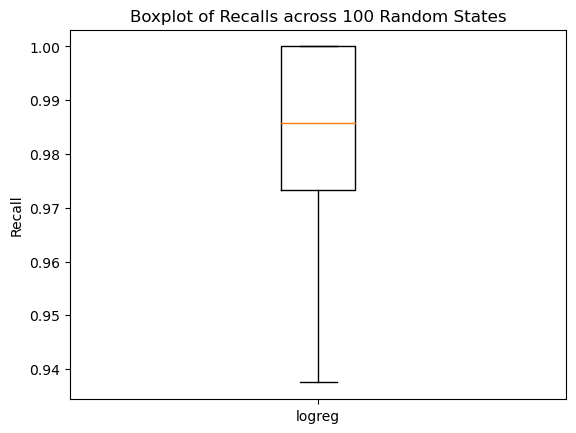

Best random state is 1 with recall of 1.0


In [5]:
safety_logreg.random_state_recall(100)

### Safety analysis on a Random Forest model

#### Grid Search

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 30}


KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


  0%|          | 0/114 [00:00<?, ?it/s]


Best Model Recall: 0.9718

Confusion Matrix (Best Model):
[[40  3]
 [ 2 69]]

Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        43
           1       0.96      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

Mean Recall across Nested Cross-Validation: 0.9581
Standard Deviation of Recall across Nested Cross-Validation: 0.0139

ROC AUC Score: 0.9980


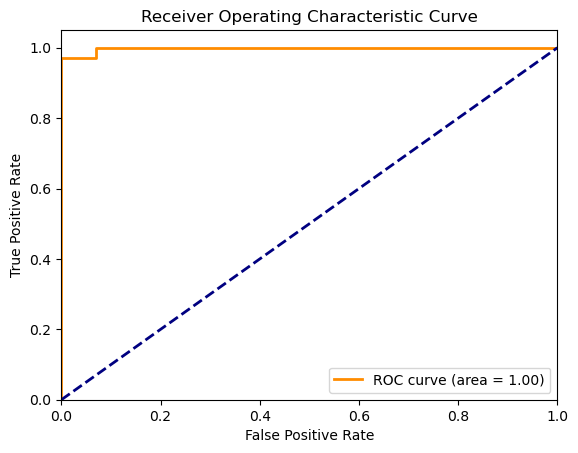

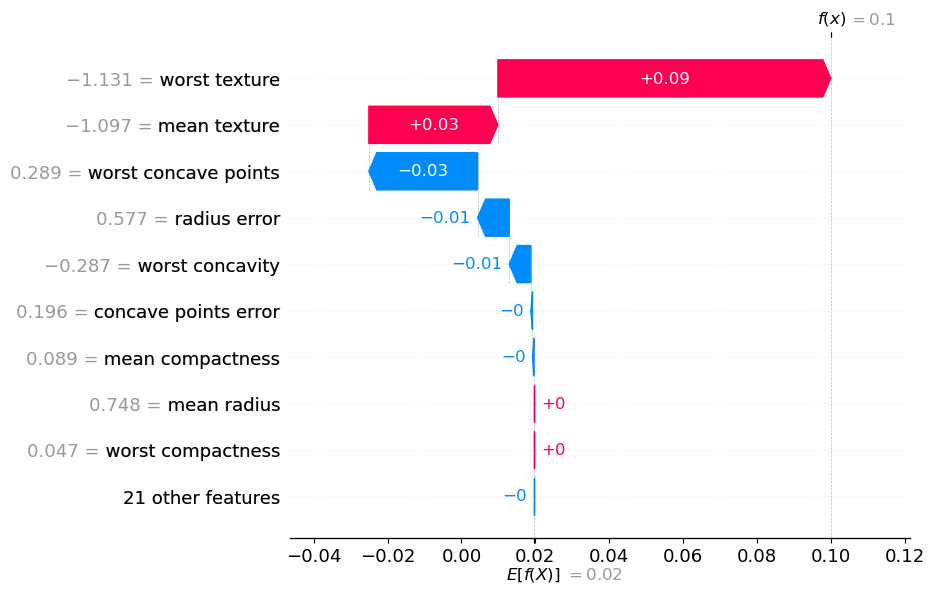

In [6]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=1)

safety_rf = Safety("rf")

safety_rf.cross_val(rf)

#### Best random state

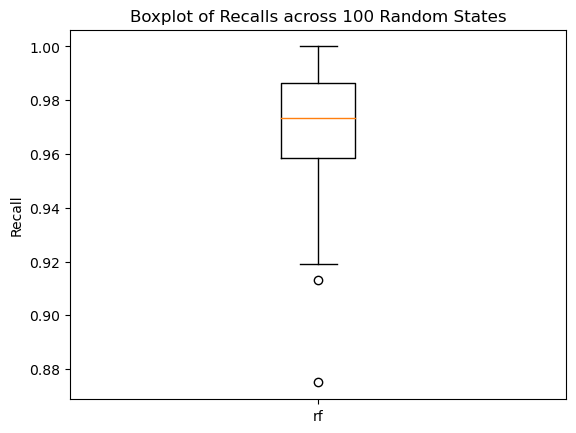

Best random state is 1 with recall of 1.0


In [7]:
safety_rf.random_state_recall(100)

### Safety analysis on a Support Vector Classifier model

#### Grid Search

Best Hyperparameters: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}


KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


  0%|          | 0/114 [00:00<?, ?it/s]


Best Model Recall: 1.0000

Confusion Matrix (Best Model):
[[37  6]
 [ 0 71]]

Classification Report (Best Model):
              precision    recall  f1-score   support

           0       1.00      0.86      0.92        43
           1       0.92      1.00      0.96        71

    accuracy                           0.95       114
   macro avg       0.96      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114

Mean Recall across Nested Cross-Validation: 0.9860
Standard Deviation of Recall across Nested Cross-Validation: 0.0070

ROC AUC Score: 0.9980


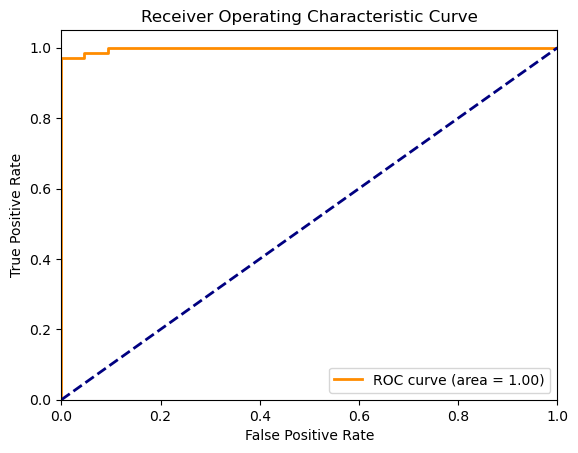

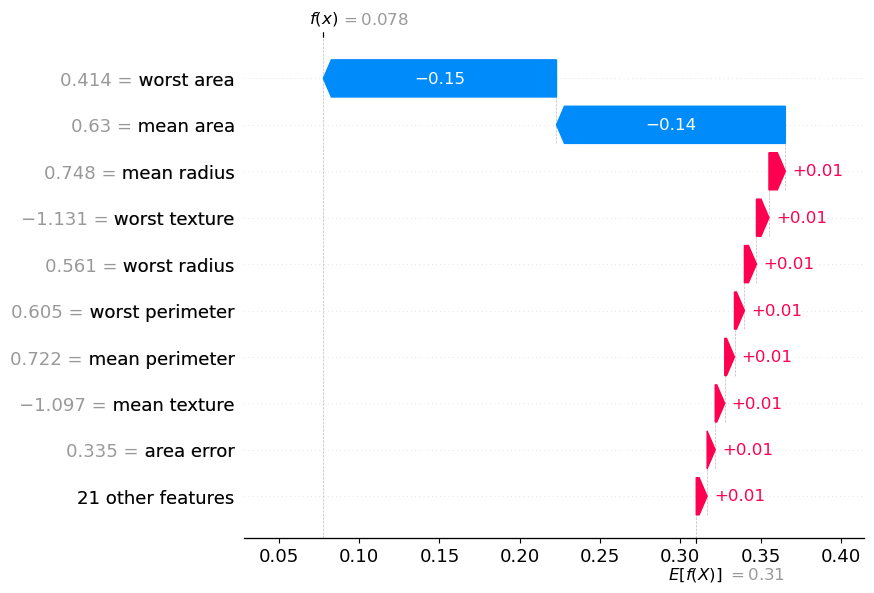

In [8]:
svc = SVC(random_state=6, probability=True)

safety_svc = Safety("svc")

safety_svc.cross_val(svc)

#### Best random state

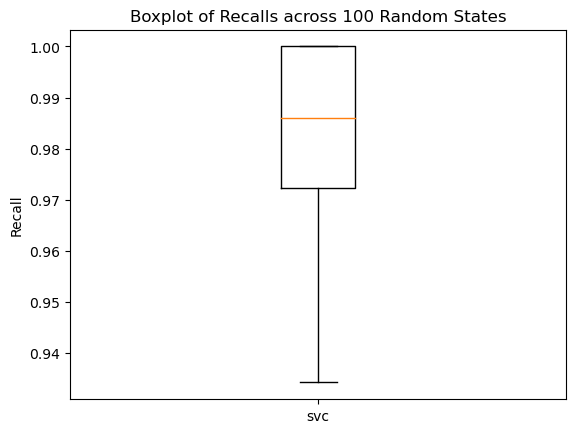

Best random state is 6 with recall of 1.0


In [9]:
safety_svc.random_state_recall(100)